# Flag QC-failed imaging wells

__Many imaging wells may have poor qualities due to different reasons, such as insufficient cells, microscopic lighting issues, etc. This notebook aims to analyze the qualities of all the imaged wells and flag the ones with poor qualities to exclude them in the downstream analyses.__

In [1]:
# Imports
import os
import warnings
import numpy as np
import polars as pl
import pandas as pd
from tqdm import tqdm
import statsmodels.formula.api as smf
from scipy.stats import ttest_rel
import matplotlib.pyplot as plt
import seaborn as sns
import sys
sys.path.append("../..")
from img_utils import *

letter_dict_rev = {v: k for k, v in letter_dict.items()}
channel_dict_rev = {v: k for k, v in channel_dict.items()}

# letter_dict_rev
channel_list = list(channel_dict_rev.values())[:-3]
channel_list

BINS = 50
%matplotlib inline

## 1. Processing QC results

__Label the QC-flag per each channel of a imaging well in every plate, based on the signal-to-noise ratio (99th-percentile pixel intensity / 25th-percentile pixel intensity) across the plate.__

1. Get the signal-to-noise ratio per each channel in each imaging well;

2. Split the distribution of the s2n ratios per each plate into 50 bins and select the first bin right edge of the first bin as our threshold;

3. Label all the imaging wells with s2n ratio below the selected threshold as is_bg, which would be discarded in the downstream analyses.

In [4]:
def get_plate_well_sum(batch, img_qc_dir, output_dir, bins=BINS, write_pq=False):
    plate_sum = pl.read_parquet(f"{img_qc_dir}/{batch}/plate_sum_stats.parquet")
    plate_well_sum = pl.read_parquet(f"{img_qc_dir}/{batch}/plate_well_sum_stats.parquet")
    # plate_site_sum = pl.read_parquet(f"../outputs/1.plate_bg_summary/{batch}/plate_site_channel.parquet")
    # plate_site_sum = plate_site_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"]).join(plate_sum, on=["plate","channel"], how="left", suffix="_plate")

    # plate_well_sum.filter(~(pl.col("channel").str.contains("Brightfield"))).sort(by=["plate","well"])
    plate_well_sum = plate_well_sum.filter(
        ~(pl.col("channel").str.contains("Brightfield"))
    ).join(
        plate_sum.rename({"perc_50": "median_plate"}), on=["plate","channel"], how="left", suffix="_plate"
    ).sort(by=["plate", "well"])

    plates = sorted(plate_well_sum["plate"].unique())
    plate_well_sum_with_metrics = pl.DataFrame()
    for plate in plates: #plate_well_sum.group_by("plate"):
        group = plate_well_sum.filter(pl.col("plate")==plate)
        # plate = group[0][0]
        # fig, axes = plt.subplots(1, 4, figsize=(15, 3))
        for channel in channel_list:
            # print(plate, channel)
            plate_channel_plate = plate_well_sum.filter(
                (pl.col("plate")==plate)&(pl.col("channel")==channel)
            ).with_columns(
                (pl.col("perc_99") / pl.col("perc_25")).alias("s2n_ratio")
            ).filter(
                (~(pl.col("s2n_ratio").is_infinite()))&(~(pl.col("s2n_ratio").is_nan()))
            ).sort(by="s2n_ratio")
            if channel == "GFP":
                plate_channel_plate = plate_channel_plate.with_columns(
                    np.log10(pl.col("s2n_ratio")+1e-4).alias("s2n_ratio")
                )
            s2n_ratios = plate_channel_plate["s2n_ratio"].to_numpy()
            counts, edges = np.histogram(s2n_ratios, bins=bins)
            # 4) the right edge of the first bin is our cutoff
            threshold = edges[1]
            plate_channel_plate = plate_channel_plate.with_columns(
                pl.lit(threshold).alias("s2n_threshold"),
                (pl.col("s2n_ratio") <= threshold).alias("is_bg")
            )
            
            # sns.histplot(plate_channel_plate["s2n_ratio"], ax=axes[channel_list.index(channel)], bins=100) # log_scale=True
            # axes[channel_list.index(channel)].axvline(threshold, color='red', linestyle='--', label='Threshold')
            # if channel == "GFP":
            #     axes[channel_list.index(channel)].set_xlabel("log10(s2n_ratio)")
            # else:
            #     axes[channel_list.index(channel)].set_xlabel("s2n_ratio")
            # axes[channel_list.index(channel)].set_title(channel)
            plate_well_sum_with_metrics = pl.concat([plate_well_sum_with_metrics, plate_channel_plate])

        # fig.suptitle(f"{plate}",y=1.05)
        # fig.subplots_adjust(wspace=0.25)

    output_pq_file = f"{output_dir}/{batch}/plate_well_sum_with_qc_metrics.parquet"
    # display(plate_well_sum_with_metrics)
    if os.path.exists(output_pq_file):
        print("Output exists at:", output_pq_file)
        
    if write_pq:
        os.makedirs(f"{output_dir}/{batch}")
        print("Writed outputs at:", output_pq_file)
        plate_well_sum_with_metrics.write_parquet(
            output_pq_file
        )
        
    return plate_well_sum_with_metrics

In [5]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch in bio_rep_batches:
        output_dir = f"{IMGS_QC_METRICS_DIR}/{bio_rep}"
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        plate_well_sum_with_metrics = get_plate_well_sum(batch, IMGS_QC_BG_SUM_DIR, output_dir, write_pq=False)

Output exists at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2024_01_Batch_7-8/2024_01_23_Batch_7/plate_well_sum_with_qc_metrics.parquet
Output exists at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2024_01_Batch_7-8/2024_02_06_Batch_8/plate_well_sum_with_qc_metrics.parquet
Output exists at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2024_12_Batch_11-12/2024_12_09_Batch_11/plate_well_sum_with_qc_metrics.parquet
Output exists at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025

In [6]:
plate_well_sum_with_metrics

shape: (12_288, 24)
┌──────────────┬──────┬─────────┬────────────┬───┬──────────────┬───────────┬──────────────┬───────┐
│ plate        ┆ well ┆ channel ┆ mean       ┆ … ┆ perc_99_plat ┆ s2n_ratio ┆ s2n_threshol ┆ is_bg │
│ ---          ┆ ---  ┆ ---     ┆ ---        ┆   ┆ e            ┆ ---       ┆ d            ┆ ---   │
│ str          ┆ str  ┆ str     ┆ f64        ┆   ┆ ---          ┆ f64       ┆ ---          ┆ bool  │
│              ┆      ┆         ┆            ┆   ┆ i64          ┆           ┆ f64          ┆       │
╞══════════════╪══════╪═════════╪════════════╪═══╪══════════════╪═══════════╪══════════════╪═══════╡
│ 2025_06_02_B ┆ E06  ┆ DAPI    ┆ 176.657285 ┆ … ┆ 692          ┆ 1.417722  ┆ 1.49297      ┆ true  │
│ 19A8A10R1_P1 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T1           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_02_B ┆ D22  ┆ DAPI    ┆ 172.893189 ┆ … ┆ 692          ┆ 1.419355  ┆ 1.49297      ┆ true  │
│ 19A8A10R1_P1 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T1           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_02_B ┆ E05  ┆ DAPI    ┆ 173.167139 ┆ … ┆ 692          ┆ 1.419355  ┆ 1.49297      ┆ true  │
│ 19A8A10R1_P1 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T1           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_02_B ┆ F05  ┆ DAPI    ┆ 173.310321 ┆ … ┆ 692          ┆ 1.419355  ┆ 1.49297      ┆ true  │
│ 19A8A10R1_P1 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T1           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_02_B ┆ G04  ┆ DAPI    ┆ 172.405434 ┆ … ┆ 692          ┆ 1.422078  ┆ 1.49297      ┆ true  │
│ 19A8A10R1_P1 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T1           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ …            ┆ …    ┆ …       ┆ …          ┆ … ┆ …            ┆ …         ┆ …            ┆ …     │
│ 2025_06_04_B ┆ O01  ┆ Mito    ┆ 402.529673 ┆ … ┆ 1628         ┆ 9.656652  ┆ 1.78363      ┆ false │
│ 19A8A10R1_P2 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T4           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_04_B ┆ I03  ┆ Mito    ┆ 394.301932 ┆ … ┆ 1628         ┆ 9.711009  ┆ 1.78363      ┆ false │
│ 19A8A10R1_P2 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T4           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_04_B ┆ G07  ┆ Mito    ┆ 351.179292 ┆ … ┆ 1628         ┆ 9.763033  ┆ 1.78363      ┆ false │
│ 19A8A10R1_P2 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T4           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_04_B ┆ M03  ┆ Mito    ┆ 427.713855 ┆ … ┆ 1628         ┆ 9.830357  ┆ 1.78363      ┆ false │
│ 19A8A10R1_P2 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T4           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ 2025_06_04_B ┆ L06  ┆ Mito    ┆ 359.044545 ┆ … ┆ 1628         ┆ 11.004237 ┆ 1.78363      ┆ false │
│ 19A8A10R1_P2 ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
│ T4           ┆      ┆         ┆            ┆   ┆              ┆           ┆              ┆       │
└──────────────┴──────┴─────────┴────────────┴───┴──────────────┴───────────┴──────────────┴───────┘

## 2. Label Poor-Quality Imaging Wells with Meta Data

In [7]:
allele_meta_dict = {}
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    for batch_id in bio_rep_batches:
        allele_meta_df = pl.DataFrame()
        platemaps = [file for file in os.listdir(PLATEMAP_DIR.format(batch_id=batch_id)) if file.endswith(".txt")]
        for platemap in platemaps:
            platemap_df = pl.read_csv(os.path.join(PLATEMAP_DIR.format(batch_id=batch_id), platemap), separator="\t", infer_schema_length=100000)
            allele_meta_df = pl.concat([allele_meta_df, 
                                        platemap_df.filter((pl.col("node_type").is_not_null()))], # (~pl.col("node_type").is_in(["TC","NC","PC"]))&
                                        how="diagonal_relaxed").sort("plate_map_name")
            allele_meta_df = allele_meta_df.with_columns(pl.col("plate_map_name").alias("plate_map")) ## str.split('_').list.get(0).
            # display(allele_meta_df.head())
        allele_meta_dict[batch_id] = allele_meta_df

In [10]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    img_well_qc_sum, well_agg_allele_qc_sum = pl.DataFrame(), pl.DataFrame()
    output_dir = f"{IMGS_QC_METRICS_DIR}/{bio_rep}"
    for batch_id in bio_rep_batches:
        ## load image qc
        plate_img_qc = pl.read_parquet(f"{output_dir}/{batch_id}/plate_well_sum_with_qc_metrics.parquet")
        if bio_rep == "2024_12_Batch_11-12":
            ## remove the widefield platemaps
            plate_img_qc = plate_img_qc.filter(~pl.col("plate").str.contains("widefield"))
            plate_img_qc = plate_img_qc.with_columns(
                pl.concat_str([pl.col("plate").str.extract(r"(B[^T]*)",1), pl.lit("_P1")]).alias("plate_id") ##.str.split('_').list.get(-2)
            ).with_columns(
                pl.concat_str([pl.col("plate_id"), pl.col("well")], separator="-").alias("plate_well")
            )
            ## load allele metadata
            allele_meta_df = allele_meta_dict[batch_id].with_columns(
                pl.concat_str([pl.col("plate_map"), pl.col("well_position")], separator="-").alias("plate_well")
            )
        elif bio_rep == "2025_01_Batch_13-14":
            ## map the plate_well together
            plate_img_qc = plate_img_qc.with_columns(
                pl.col("plate").str.split('_').list.get(-2).alias("plate_id"),
            ).with_columns(
                pl.concat_str([pl.col("plate_id"),pl.col("well")], separator="-").alias("plate_well")
            )
            # print(plate_img_qc)
            allele_meta_df = allele_meta_dict[batch_id].with_columns(
                pl.col("plate_map").str.split('_').list.get(0).alias("plate")
            ).with_columns(
                pl.concat_str([pl.col("plate"), pl.col("well_position")], separator="-").alias("plate_well")
            )
        else:
            ## map the plate_well together
            plate_img_qc = plate_img_qc.with_columns(
                pl.col("plate").str.extract(r"(B[^T]*)",1).alias("plate_id") ##.str.split('_').list.get(-2)
            ).with_columns(
                pl.concat_str([pl.col("plate_id"),pl.col("well")], separator="-").alias("plate_well")
            )
            ## load allele metadata
            allele_meta_df = allele_meta_dict[batch_id].with_columns(
                pl.concat_str([pl.col("plate_map"), pl.col("well_position")], separator="-").alias("plate_well")
            )
            
        if "plate" in allele_meta_df.columns:
            allele_meta_df = allele_meta_df.drop("plate", "plate_map")
        else:
            allele_meta_df = allele_meta_df.drop("plate_map")
        
        plate_img_qc = plate_img_qc.join(
            allele_meta_df, 
            on="plate_well", how="left"
        ).filter(
            (pl.col("gene_allele").is_not_null())
        )
        img_well_qc_sum = pl.concat([img_well_qc_sum, plate_img_qc], how="diagonal_relaxed")
        
        # for channel in channel_list:
        #     plate_img_qc_ch = plate_img_qc.filter(pl.col("channel")==channel)
        #     plate_maps = sorted(plate_img_qc_ch["plate_map_name"].unique())
        #     # print(plate_maps)
        #     # for plate_map in plate_maps:
        #     #     plate_img_qc_ch_pm = plate_img_qc_ch.filter(pl.col("plate_map_name")==plate_map)
        #     #     plates = sorted(plate_img_qc_ch_pm["plate"].unique().to_list())
        #     #     # print(plates)
        #     #     plot_platemap(
        #     #         plate_img_qc_ch_pm.filter(pl.col("plate")==plates[0]),
        #     #         plates[0]+f"_{channel}",
        #     #         well_pos_col="well",
        #     #         # this is the column to color by (categorical or continuous)
        #     #         value_col="node_type",
        #     #         # these columns will be concatenated into the annotation text
        #     #         label_cols=("gene_allele",),
        #     #         value_type="categorical",   # or "continuous"
        #     #         continuous_cmap="vlag",  # matplotlib colormap for continuous mode
        #     #         # categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
        #     #         grid_square=None
        #     #     )
        #     #     break
        #     #     fig, axes = plt.subplots(2,2,figsize=(44,23)) ## sharey=True,sharex=True
        #     #     for plate in plates:
        #     #         plate_info = plate_img_qc_ch_pm.filter(pl.col("plate")==plate)
        #     #         # display(plate_info.filter(pl.col("is_bg")))
        #     #         # print(plates.index(plate))
        #     #         plot_platemap(
        #     #             plate_info,
        #     #             plate+f"_{channel}",
        #     #             well_pos_col="well",
        #     #             # this is the column to color by (categorical or continuous)
        #     #             value_col="is_bg",
        #     #             # these columns will be concatenated into the annotation text
        #     #             label_cols=("gene_allele",),
        #     #             ax=axes[plates.index(plate)//2, plates.index(plate)%2],
        #     #             value_type="categorical",   # or "continuous"
        #     #             continuous_cmap="vlag",  # matplotlib colormap for continuous mode
        #     #             categorical_colors={True: "tomato", False: "skyblue"},     # dict for categorical → color
        #     #             grid_square=None
        #     #         )
        #     #     fig.subplots_adjust(wspace=-.61, hspace=.05)
        #     #     plt.tight_layout()
        #     #     break
        #     well_img_qc_ch_sum_batch = plate_img_qc_ch.group_by(["gene_allele","well"]).agg(
        #         pl.col("is_bg").sum().alias("is_bg_sum"),
        #     ).with_columns(
        #         pl.lit(batch_id).alias("Batch"),
        #         pl.when(pl.col("is_bg_sum")>=3)
        #         .then(pl.lit("FAIL"))
        #         .otherwise(pl.lit("PASS"))
        #         .alias("QC_Flag")
        #     )
        #     well_agg_allele_qc_sum = pl.concat([well_agg_allele_qc_sum, well_img_qc_ch_sum_batch])

    # print("Writed outputs at:", f"{output_dir}/allele-level_img_qc_sum.csv")
    # well_agg_allele_qc_sum.write_csv(f"{output_dir}/allele-level_img_qc_sum.csv")
    print("Writed outputs at:", f"{output_dir}/plate-well-level_img_qc_sum.csv")
    # img_well_qc_sum.write_csv(f"{output_dir}/plate-well-level_img_qc_sum.csv")

Writed outputs at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2024_01_Batch_7-8/plate-well-level_img_qc_sum.csv
Writed outputs at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2024_12_Batch_11-12/plate-well-level_img_qc_sum.csv
Writed outputs at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/2025_03_Batch_15-16/plate-well-level_img_qc_sum.csv
Writed outputs at: /home/shenrunx/igvf/varchamp/2025_laval_submitted/2_individual_assay_results/imaging/2_analysis/1_snakemake_pipeline/2025_varchamp_snakemake/3.downstream_analyses/inputs/plate_well_qc_metrics/20

## 3. Visualize wells

In [6]:
OUT_IMGS_DIR = ""
from display_img import *

<Figure size 640x480 with 0 Axes>

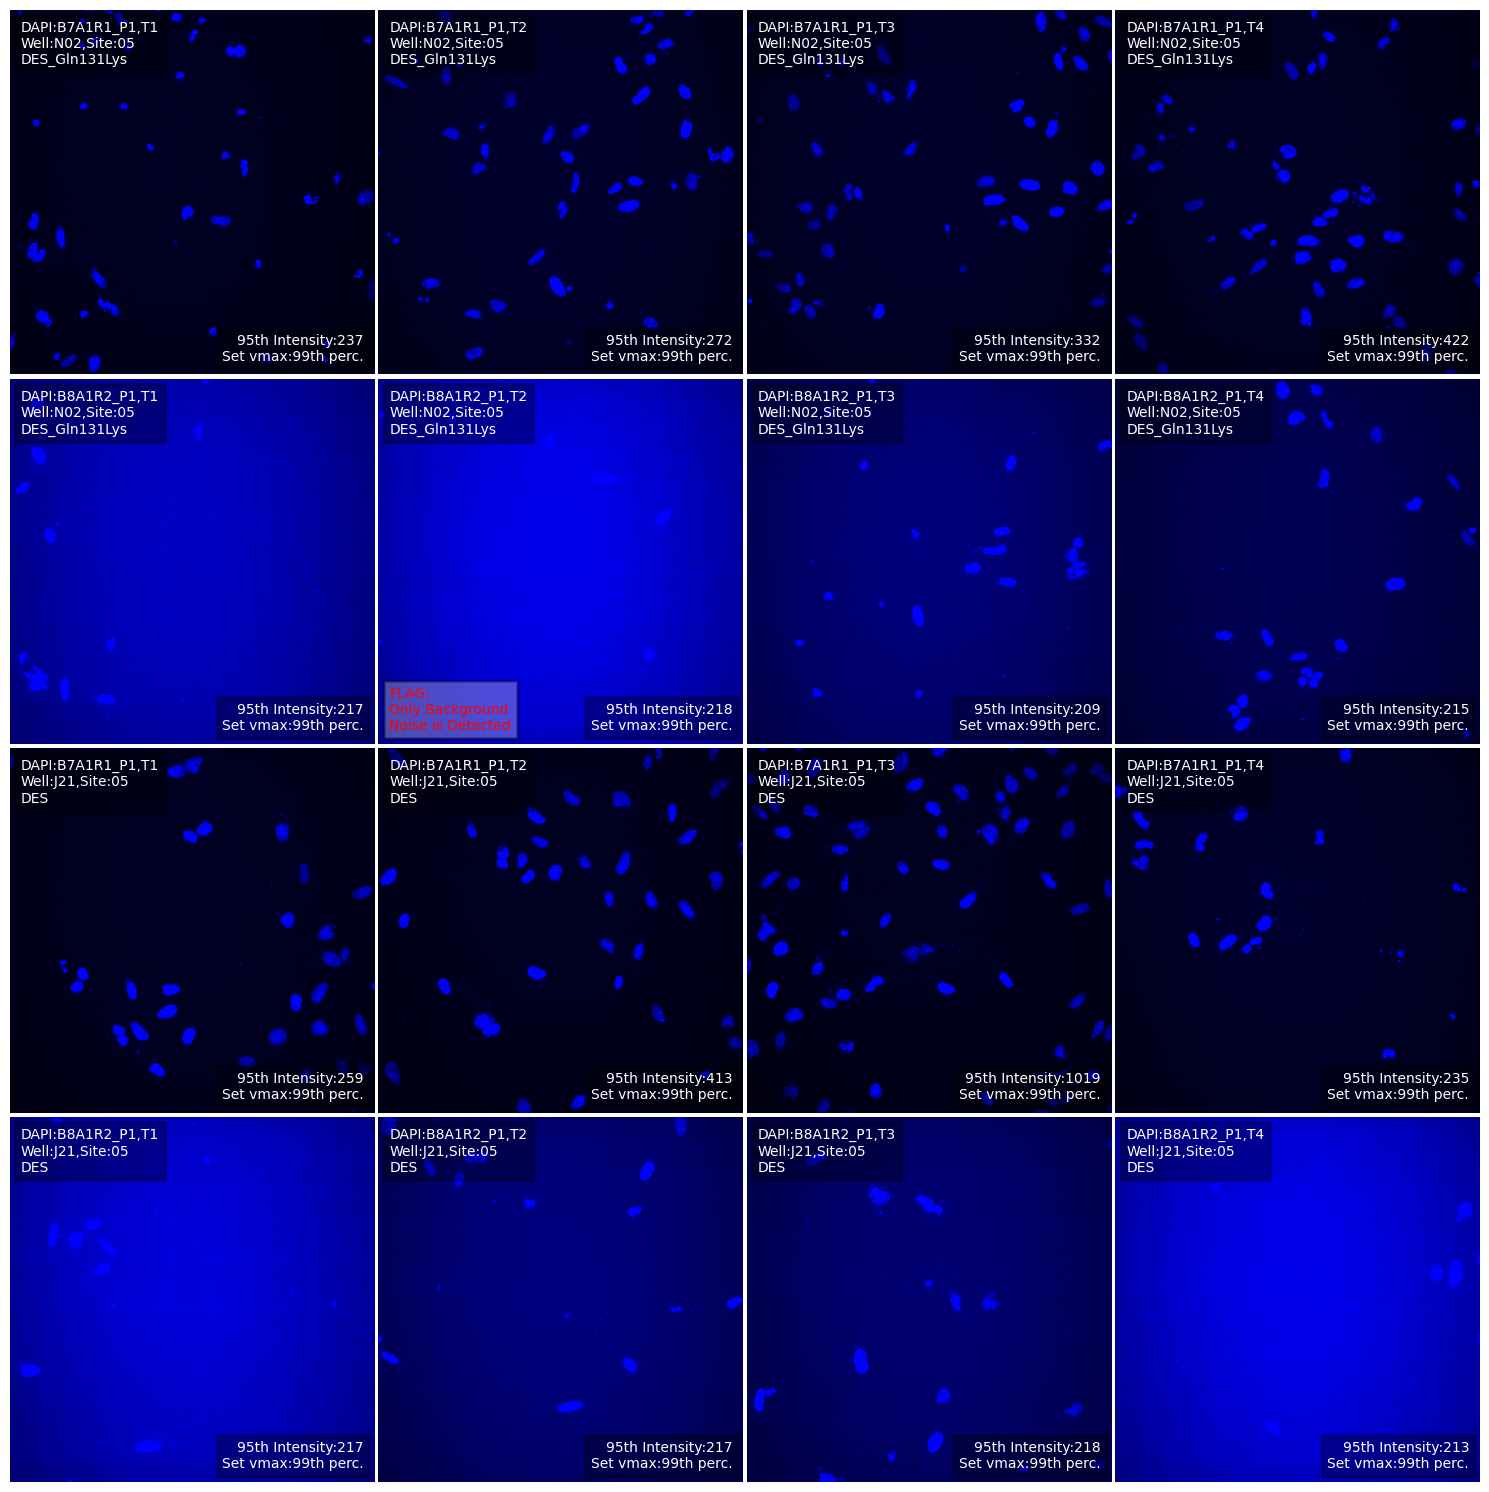

<Figure size 640x480 with 0 Axes>

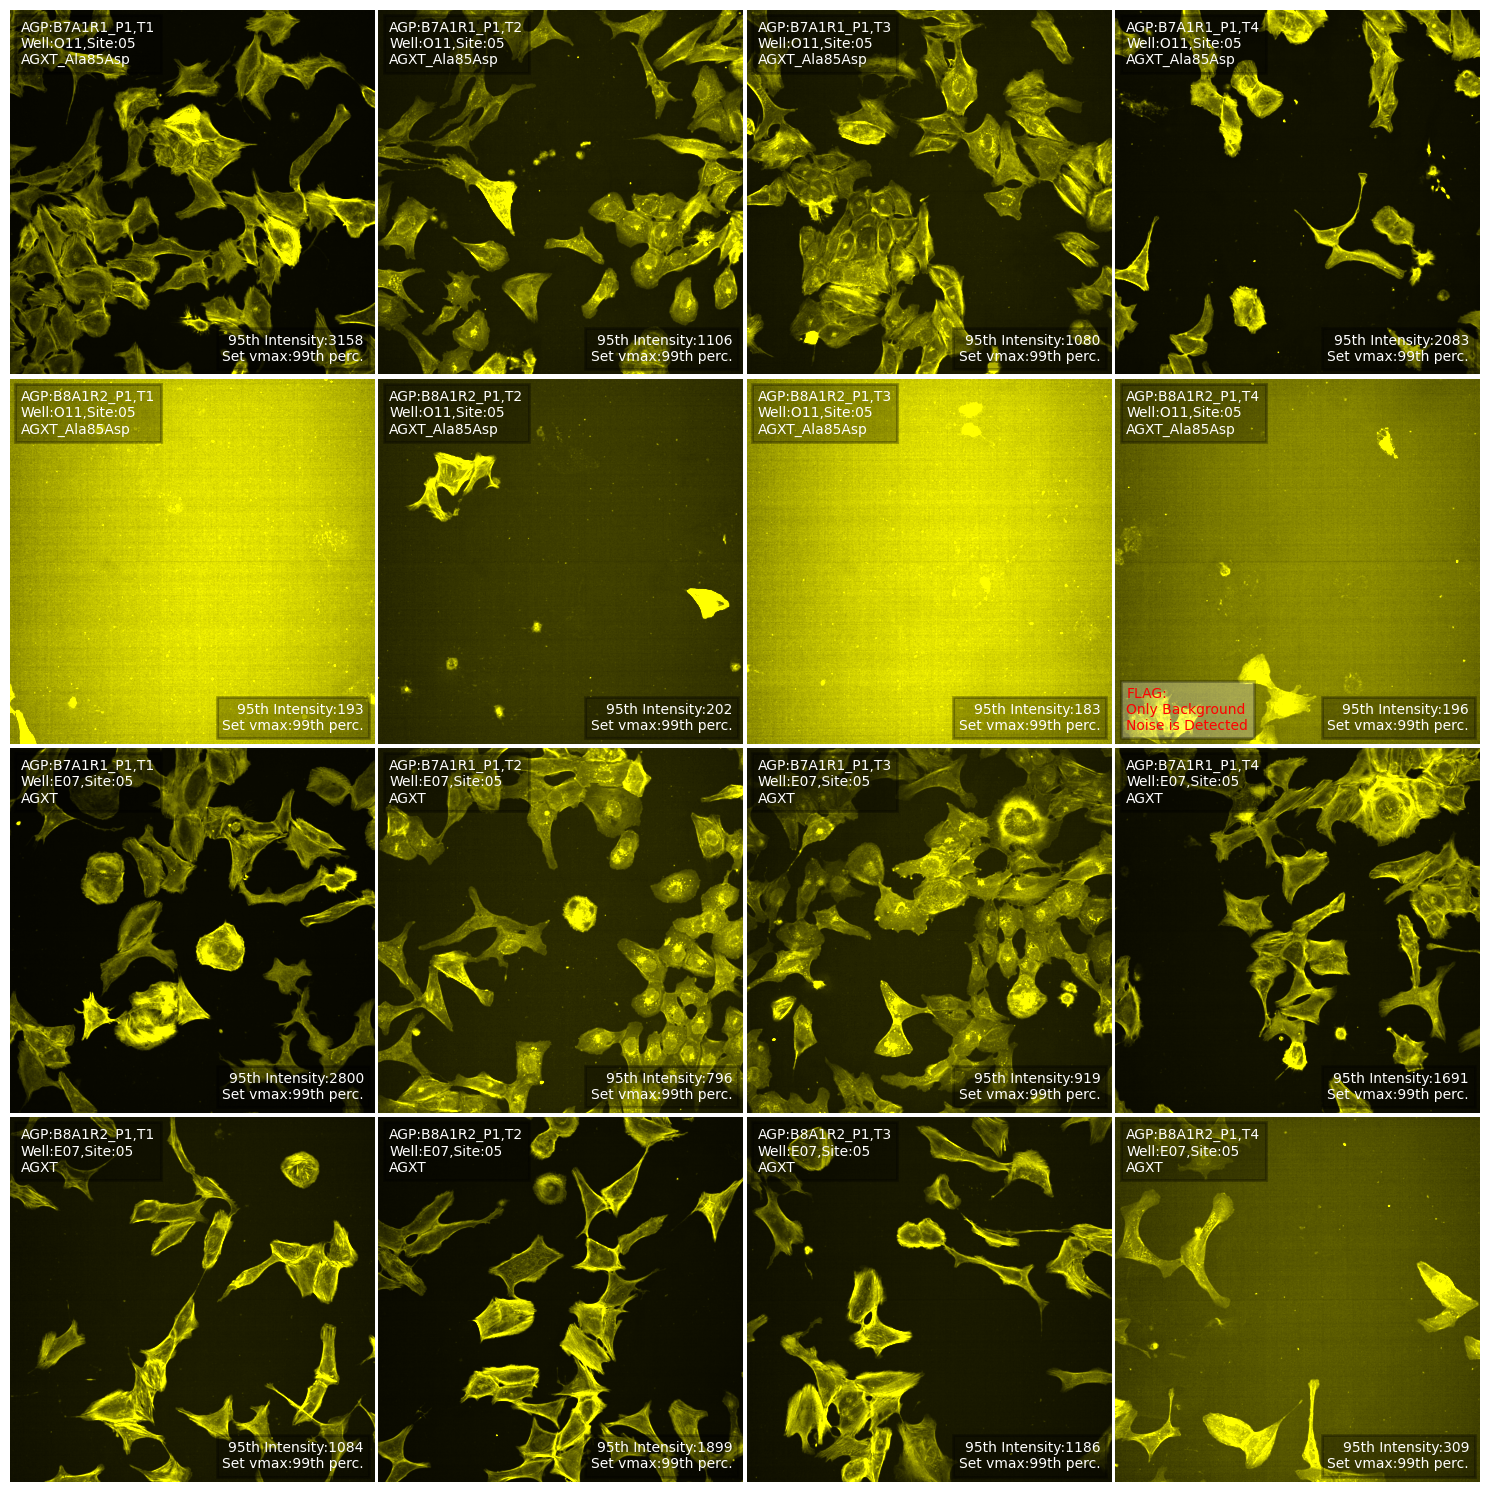

<Figure size 640x480 with 0 Axes>

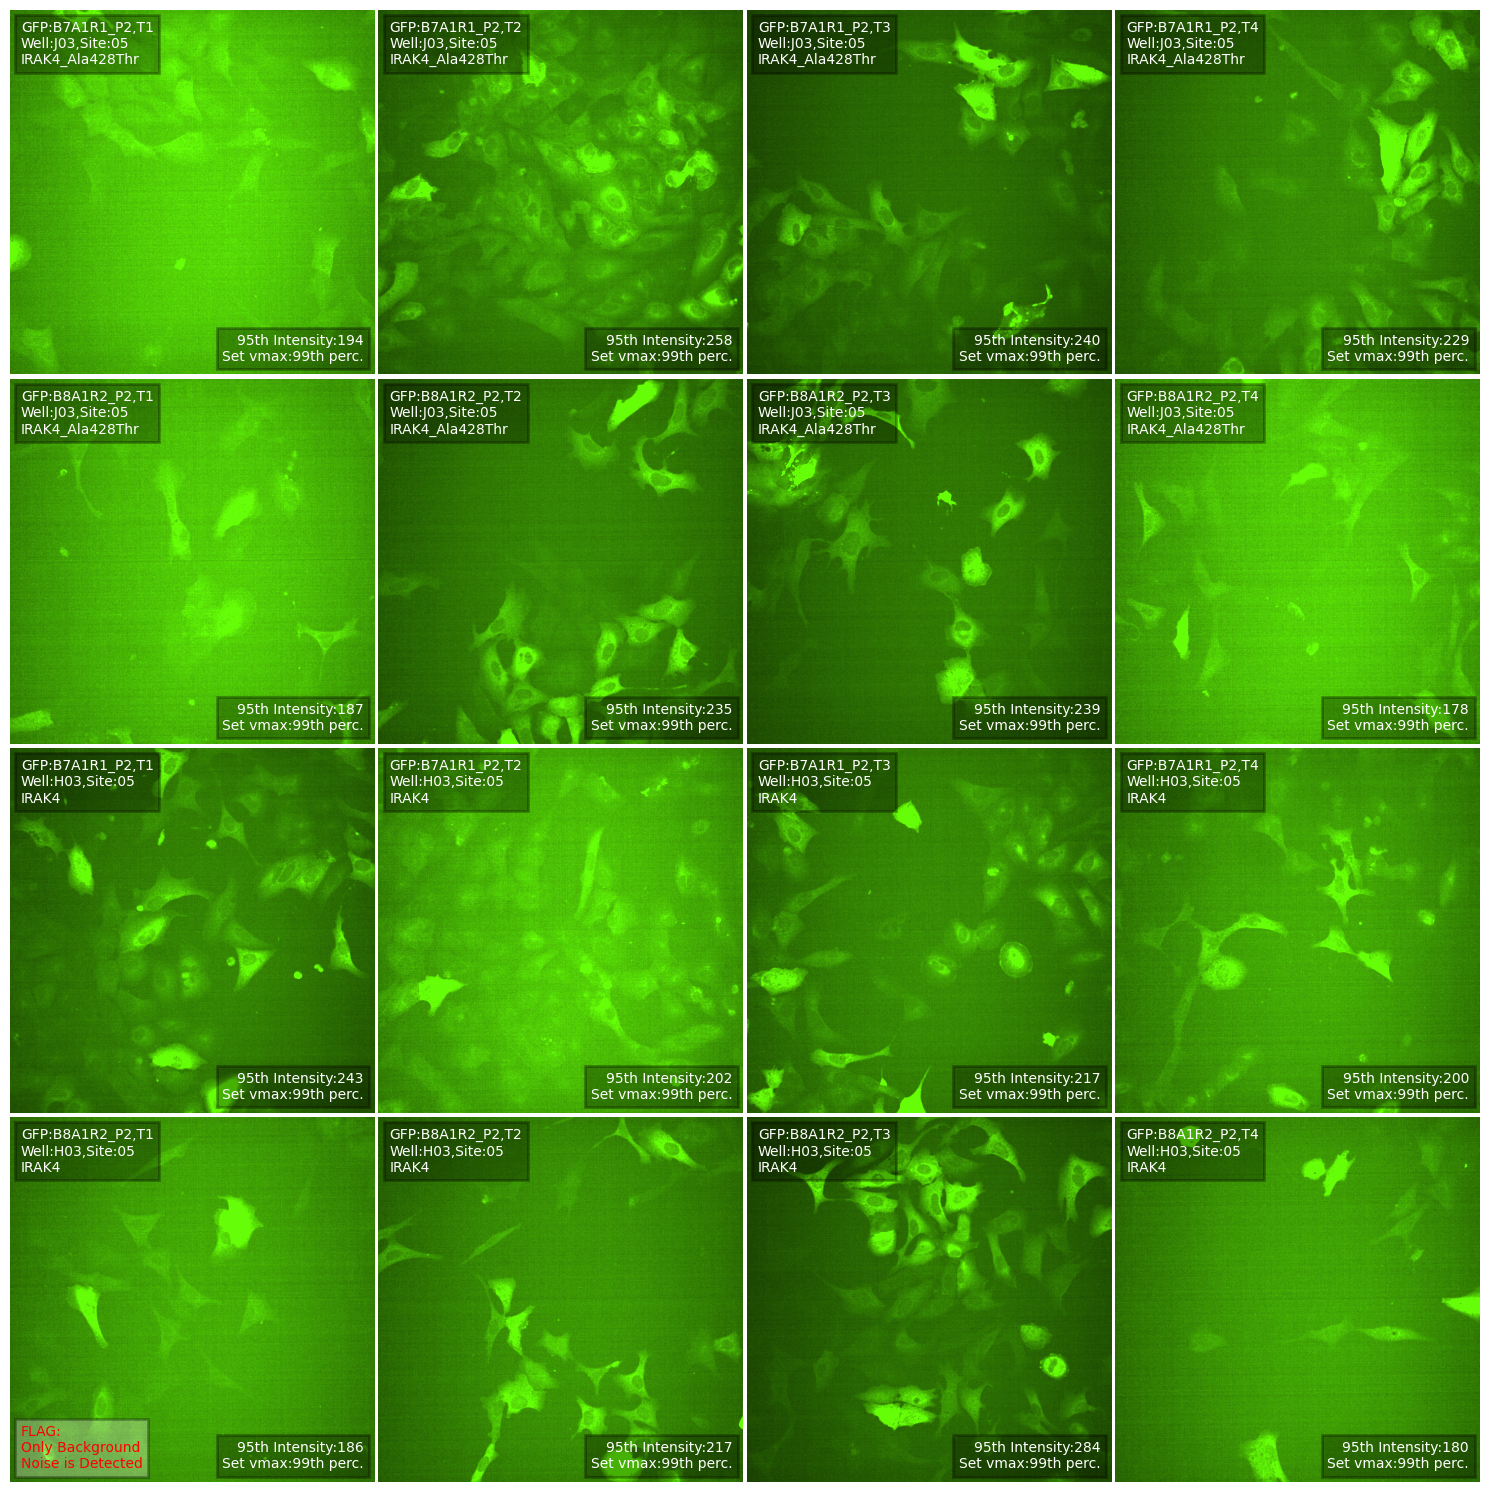

<Figure size 640x480 with 0 Axes>

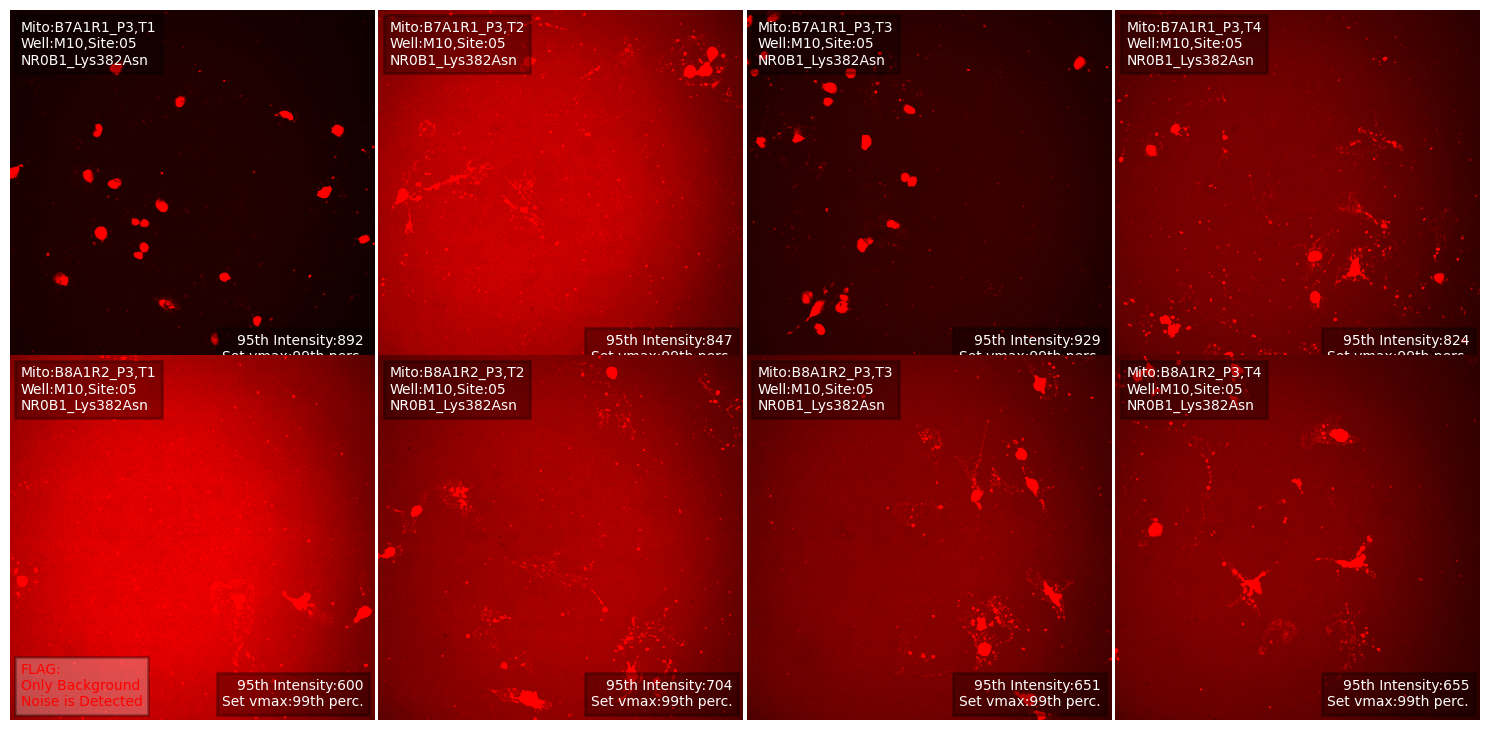

In [5]:
for bio_rep, bio_rep_batches in BIO_REP_BATCHES_DICT.items():
    output_dir = f"{IMGS_QC_METRICS_DIR}/{bio_rep}"
    img_well_qc_sum = pl.read_csv(f"{output_dir}/plate-well-level_img_qc_sum.csv")
    img_well_qc_sum_bg = img_well_qc_sum.filter(pl.col("is_bg"))
    img_well_qc_sum_group = img_well_qc_sum_bg.group_by(["plate","channel"]).agg(
        pl.len().alias("bg_counts")
    ).sort(by=["channel", "bg_counts"], descending=True)
    # display(img_well_qc_sum_group)

    for channel in img_well_qc_sum_group["channel"].unique():
        # if channel != "GFP":
        #     continue
        img_well_qc_sum_group_ch = img_well_qc_sum_group.filter(pl.col("channel")==channel)
        poor_qc_plate = img_well_qc_sum_group_ch.row(0)[0]
        img_well_qc_sum_bg_plate_ch = img_well_qc_sum_bg.filter(
            (pl.col("channel")==channel)&(pl.col("plate")==poor_qc_plate)
        ).sort(by="s2n_ratio", descending=True)
        qc_allele = img_well_qc_sum_bg_plate_ch.head(1)["gene_allele"][0]
        # print(qc_allele, poor_qc_plate)
        if "_" not in qc_allele:
            ref_well = img_well_qc_sum_bg_plate_ch.head(1)["well_position"][0]
            # display(allele_meta_dict[bio_rep_batches[0]].filter(pl.col("gene_allele").str.contains(f"{qc_allele}_")))
            qc_allele = allele_meta_dict[bio_rep_batches[0]].filter(pl.col("gene_allele").str.contains(f"{qc_allele}_")).head(1)["gene_allele"][0]
            # display(img_well_qc_sum_bg_plate_ch.filter(pl.col("gene_allele").str.contains(f"{qc_allele}_")))
            plot_allele(allele_meta_dict[bio_rep_batches[0]], qc_allele, channel, ref_well=[ref_well], 
                        plate_img_qc=img_well_qc_sum, site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)
        else:
            plot_allele(allele_meta_dict[bio_rep_batches[0]], qc_allele, channel, 
                        plate_img_qc=img_well_qc_sum, site="05", max_intensity=0.99, display=True, imgs_dir=TIFF_IMGS_DIR)
    break

In [10]:
# allele_meta_dict[bio_rep_batches[0]].filter(pl.col("symbol")=="NR0B1")